# Step5 演習06 エコーステートネットワーク
---

本演習では、エコーステートネットワークをスクラッチで実装し、周波数から波を生成するモデルを作成します。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- エコーステートネットワークをスクラッチで実装しネットワークへの理解を深める

**【課題１】** 採点を実行してください。

本演習は自動採点を行いません。回答はヒントを参考にしてください。

In [1]:
#Coursedele-02 Step5 QuestionNumber19 2f37aec7d3fd9caf62befb812ad2b800
print("この課題の採点は全員正解とします。")

この課題の採点は全員正解とします。


** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [2]:
%%bash
./validation_client.py dele-02 5 19 Step5_06.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## ライブラリのインストール

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scipy](https://www.scipy.org/) 公式ドキュメント


`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
%matplotlib inline 

## データ・セットの準備

### データの生成

まずこの演習で使用するデータ・セットの作成を行います。ここでは、`N`時間の間に周期が`n_change`回変化する最低周期`min_period`、最大周期`max_period`を持つ波形をN時間ステップ分生成します。

関数`frequency_gen`は上記の引数を受け取り、入力周波数`x`と出力波`y`を返します。

In [4]:
rng = np.random.RandomState(1234)
def frequency_gen(N, min_period, max_period, n_change):
    change = np.insert(np.sort(rng.randint(1,N,n_change)),[0,n_change],[0,N])
    x = np.zeros(N)
    y = np.zeros(N)
    z = 0
    for i in range(N):
        if i in change:
            T = rng.randint(min_period, max_period)
        z = z + 2*np.pi*1./T
        x[i] = 1./T
        y[i] = np.sin(z)
    return x, y

では実際に上の関数を使ってデータ・セットを生成します。

In [5]:
N = 20000
min_period = 10
max_period = 20
n_change = 200
x_data, y_data = frequency_gen(N, min_period, max_period, n_change)
# x_data, y_dataに次元を追加
x_data = np.expand_dims(x_data, 1)
y_data = np.expand_dims(y_data, 1)
print('x_data.shape:', x_data.shape)
print('y_data.shape:', y_data.shape)

x_data.shape: (20000, 1)
y_data.shape: (20000, 1)


### データの正規化

x_dataとy_dataの最小値と最大値がそれぞれ0と１になるように正規化します。

In [6]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

In [7]:
x_scaled = min_max_scaler(x_data)
y_scaled = min_max_scaler(y_data)

### データの分離

データを学習用データとテスト用データに分離します。ここでは全データの８割を学習用データとします。

In [8]:
train_size = int(N*0.8)
test_size = N - train_size
x_train, y_train = x_scaled[:train_size], y_scaled[:train_size]
x_test, y_test = x_scaled[train_size:], y_scaled[train_size:]

### データの可視化

データを一部可視化してみます。青の線が入力周波数で、緑の波が出力です。入力が大きくなると出力波形の周波数が上がっているのが確認できると思います。

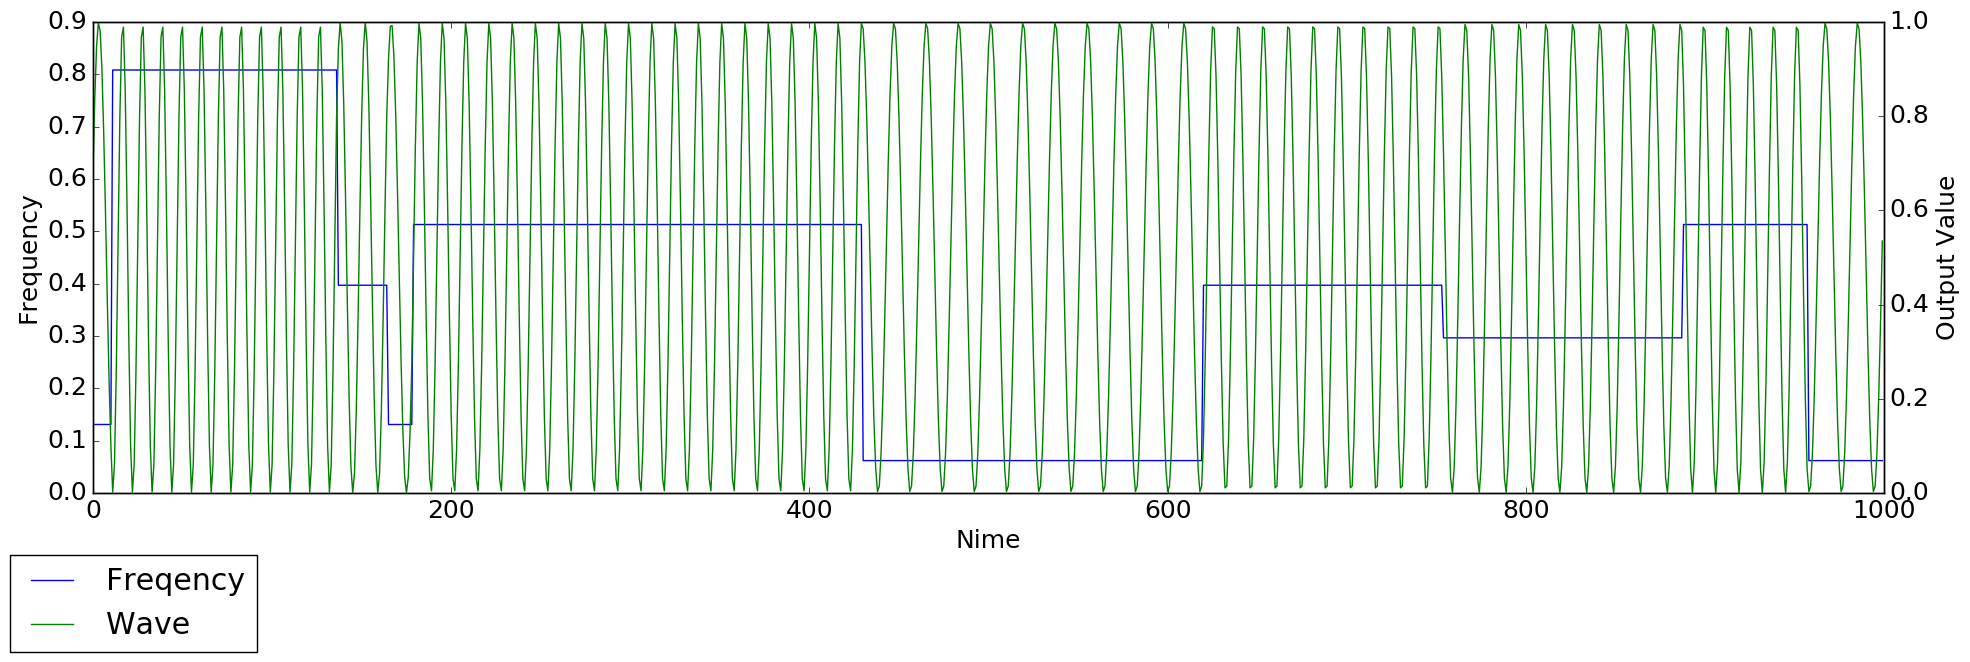

In [9]:
plt.rc('font', size=18) 
fig, ax1 = plt.subplots(figsize=(20, 6))
lns1 = ax1.plot(x_scaled[:1000], label='Freqency', color='b')
ax1.set_xlabel('Nime')
ax1.set_ylabel('Frequency')
ax2 = ax1.twinx()
lns2 = ax2.plot(y_scaled[:1000], label='Wave', color='g')
ax2.set_ylabel('Output Value')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, bbox_to_anchor=(0.1, -0.1))
fig.tight_layout()

## モデルの実装

エコーステートネットワークのリザーバのユニット数を$N$, 入力次元を$K$、出力次元を$L$としたときのモデルの式は以下のようになります。
$$
\boldsymbol{x}(n) = f(\boldsymbol{W}\boldsymbol{x}(n-1) + 
                      \boldsymbol{W_{in}}\boldsymbol{u}(n) +
                      \boldsymbol{W_{fb}}\boldsymbol{y}(n-1))　\tag{1.1}
$$
ここで、
- $\boldsymbol{x}(n)$: 時刻nにおけるリザーバ状態
- $f$: tanhなどの活性化関数
- $\boldsymbol{W}$: $N\times N$次元の重み
- $\boldsymbol{W_{in}}$: $N\times K$次元の重み
- $\boldsymbol{u}(n)$: 時刻nにおける$K$次元の入力
- $\boldsymbol{W_{fb}}$: $N\times L$次元の重み
- $\boldsymbol{y}(n)$: 時刻nにおける$L$次元の出力（**注意！！**：訓練時の$\boldsymbol{y}(n)$は正解データ（教師強制））

です。そしてモデルの出力は、以下の式から求めることができます。
$$
\boldsymbol{z}(n)=[\boldsymbol{x}(n);\boldsymbol{u}(n)] \tag{2.1}
$$
$$
\boldsymbol{y}(n) = g(\boldsymbol{W_{out}}\boldsymbol{z}(n))  \tag{2.2}
$$
ここで、式(2.2)は入力$\boldsymbol{u}(n)$と出力$\boldsymbol{x}(n)$を結合したものです。そして、
- $g$: tanhなどの活性化関数
- $\boldsymbol{W_{out}}$: $N\times (K+N)$次元の重み

です。

エコーステートネットワークでは出力層の重み以外はランダムなままで固定し、出力層の重み($\boldsymbol{W_{out}}$)のみを学習します。コスト関数を平均二乗誤差とすると、最適後の重み$\boldsymbol{W_{out}'}$は正規方程式から簡単に導き出せます。

$$
\boldsymbol{y} = tanh(\boldsymbol{z}\boldsymbol{W_{out}'}) \tag{3.1}
$$
$$
\boldsymbol{W_{out}'} = (\boldsymbol{z}^\top \boldsymbol{z})^{-1} \boldsymbol{z}^\top arctanh(\boldsymbol{y}) \tag{3.2}
$$
ここで式(3.1)では行列計算のために変数の$\boldsymbol{z}$と$\boldsymbol{W_{out}'}$の順序を入れ替えています。この計算なのですが、実はnumpyの[np.linalg.pinv](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.pinv.html)を使うと$(\boldsymbol{z}^\top \boldsymbol{z})^{-1} \boldsymbol{z}^\top$の部分を一発で効率よく求めてくれるのでこの関数を使いましょう。

### 重みの初期化

ここでは入力からリザーバ`Win`への重み、リザーバ内の重み`W`、出力からリザーバ`Wfb`への重みを初期化します。

関数`init_weights`には５つの引数があります。
- n_res: リザーバのユニット数
- n_in: 入力の次元
- nout: 出力の次元
- sparsity: スパース度
- spectral_radius: スペクトル半径

`W`は慎重に初期化する必要があります。ここでは、まず平均0、分散0.5のガウス分布からサンプリングします。次に、スパース度に応じて、重みをゼロにします。次に、`W`のスペクトル半径`radius`を計算します。`W`のスペクトル半径は`W`の最大固有値の絶対値と定義されています。これを用いて一旦重みのスペクトル半径が1になるように、重みを計算したスペクトル半径で割ります。その後、引数のスペクトル半径をかけて重みのスペクトル半径を決定します。

`Win`と`Wfb`は正規分布からサンプリングします。

In [10]:
def init_weights(n_res, n_in, n_out, sparsity, spectral_radius):
    W = rng.normal(scale=0.5, size=(n_res,n_res))
    W[rng.rand(*W.shape) < sparsity] = 0
    radius = max(abs(np.linalg.eigvals(W)))
    W /= radius # スペクトル半径をまず１にする
    W *= spectral_radius # スペクトル半径を決定 
    Win = rng.normal(size=(n_res, n_in))
    Wfb = rng.normal(size=(n_res, n_out))
    return [W, Win, Wfb]

In [11]:
n_res = 250
n_in = n_out = 1
sparsity = 0.95
spectral_radius = 0.25
weights = init_weights(n_res, n_in, n_out, sparsity, spectral_radius)

### リザーバ状態の更新

**【確認１】**　リザーバ内の状態を更新する関数を作成します。

ここでは式(1.1)に従って状態`state`を更新します。活性化関数はtanhを使用します。

関数`update_state`には3つの引数があります。
- weights: W, Win, Wfbを格納
- x: 時刻(n-1)の状態
- u: 時刻(n)のの入力
- y: 時刻(n-1)の出力

モデルの出力を安定化させるために、ここでは`next_state`に微小なノイズを加えます。

In [12]:
def update_state(weights, x, u, y):
    W, Win, Wfb = weights
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    next_state = np.tanh(np.dot(W, x) + np.dot(Win, u) + np.dot(Wfb, y))
    ################END CODE HERE################
    noise=0.001
    next_state += noise * (rng.rand(x.shape[0]) - 0.5)
    return next_state 

### 学習コードの作成

**【確認２】**　ここではエコーステートネットワークを学習させるためのコードを書きます。

関数`train`は５つの引数があります。
- weights: W, Win, Wfbを格納
- x_train: 学習用データの入力
- y_train: 学習用データの出力
- input_scale_shift: 入力をスケーリングとシフトさせるために必要なパラメータ( \[float, float\] )
- output_scale_shift: 出力をスケーリングとシフトさせるために必要なパラメータ ( \[float, float\] )

この関数では、

- x_train_scaled, y_train_scaled: 入出力対してスケーリングとシフト
- states: reservoir状態の初期化
- x: 時刻(n-1)の状態`states`を取得
- u: 時刻(n)の入力`x_train_scaled`を取得
- y: 時刻(n-1)の出力`ｙ_train_scaled`を取得（教師強制）
- states\[n\]: 状態を関数`update_state`を使って更新
- extended_states: 式(2.1)に従って状態と入力を結合（np.hstackを使用)
- Wout: 式(3.2)に従ってWoutを計算（np.linalg.pinvを使用）
- y_pred: 式(3.1)に従って出力を計算、その後シフト、スケール分を元に戻す
- mse: 平均二乗誤差の計算
- last_state, last_output: テスト時に必要な状態と出力を保存

In [13]:
def train(weights, x_train, y_train, input_scale_shift, output_scale_shift, train_size, n_res):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    # 入出力対してスケーリングとシフト
    x_train_scaled = x_train * input_scale_shift[0] + input_scale_shift[1]
    y_train_scaled = y_train * output_scale_shift[0] + output_scale_shift[1]
    # reservoir状態をゼロ初期化
    states = np.zeros((train_size, n_res))
    for n in range(1, x_train.shape[0]):
        # １時刻前の状態
        x = states[n-1]
        # 現在時刻の入力
        u = x_train_scaled[n]
        # １時刻前の出力（正解データ）
        y = y_train_scaled[n-1]
        # 式(1.1)
        states[n] = update_state(weights, x, u, y)
    # 式(2.1)
    extended_states = np.hstack((states, x_train_scaled)) # Z
    # 式(3.2)
    Wout = np.dot(np.linalg.pinv(extended_states), np.arctanh(y_train_scaled))
    # 式(3.1)
    y_pred = np.tanh(np.dot(extended_states, Wout))
    # 出力に対してスケーリングとシフト分を元に戻す
    y_pred = (y_pred -output_scale_shift[1]) / output_scale_shift[0]
    ################END CODE HERE################
    # 平均二乗誤差の計算
    mse = np.sqrt(np.mean((y_pred-y_train)**2))
    # テスト時に必要な状態と出力を保存
    last_state = states[-1]
    last_output = y_train_scaled[-1]
    return Wout, y_pred, mse, last_state, last_output

### 学習コードの確認

では実際に関数`train`を使ってみます。

In [14]:
input_scale_shift = [3, 0.]
output_scale_shift = [1.3, -0.6]
Wout, y_pred_train, mse, last_state, last_output = train(weights, x_train, y_train, 
                                                         input_scale_shift, output_scale_shift, train_size, n_res)
print("平均二乗誤差：{:.3e}".format(mse))

平均二乗誤差：3.582e-03


モデルの出力をプロットしてみます。ほぼ完璧に出力データと一致しているのが確認できると思います。

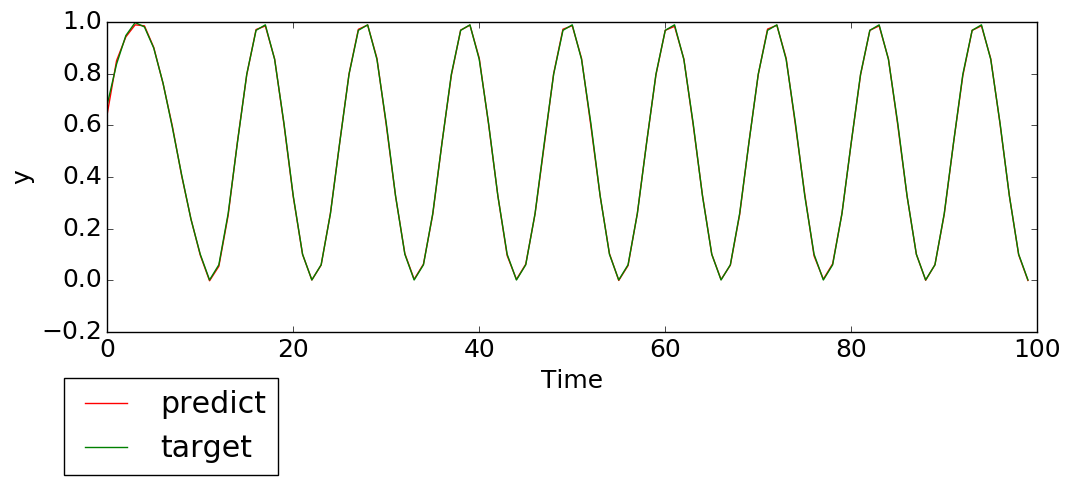

In [15]:
plt.figure(figsize=(12,4))
plt.plot(y_pred_train[:100], 'r', label='predict')
plt.plot(y_train[:100], 'g', label='target')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(0.2, -0.1))

### テストコードの作成

**【確認３】**　ここでは学習したWoutをテスト用データをテストするコードを作成します。

関数`test`は8つの引数があります。
- weights: W, Win, Wfbを格納
- x_test: テスト用データの入力
- y_test: テスト用データの出力
- Wout: 学習した出力層の重み
- last_state: 学習時の最後のreservoirの状態
- last_output: 学習の最後の出力
- input_scale_shift: 入力をスケーリングとシフトさせるために必要なパラメータ( \[float, float\] )
- output_scale_shift: 出力をスケーリングとシフトさせるために必要なパラメータ ( \[float, float\] )

この関数では、

- x_test_scaled, y_test_scaled: 入出力対してスケーリングとシフト
- y_pred: 出力を格納するための配列の作成
- x: 時刻(n-1)の状態を取得
- y: 時刻(n-1)の出力を取得
- u: 時刻(n)の入力を取得

- state: 状態を関数`update_state`を使って更新
- z: 式(2.1)に従って状態と入力を結合（np.hstackを使用)
- y_pred[n]: 式(3.1)に従って出力を計算
- y_pred: シフト、スケール分を元に戻す
- mse: 平均二乗誤差の計算

In [16]:
def test(weights, x_test, y_test, Wout, last_state, last_output, input_scale_shift, output_scale_shift, test_size, n_out):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    # 入出力対してスケーリングとシフト
    x_test_scaled = x_test * input_scale_shift[0] + input_scale_shift[1]
    y_test_scaled = y_test * output_scale_shift[0] + output_scale_shift[1] 
    # 出力を格納するための配列（ゼロ初期化）
    y_pred = np.zeros((test_size, n_out))
    for n in range(test_size):
        # 時刻(0)のみ学習時の最後の状態と出力を使用
        if n==0:
            # 学習時のreservoirの最後の状態
            x = last_state
            # 学習時の最後の出力
            y = last_output
        else:
            # １時刻前の状態 (state)
            x = state
            # １時刻前の出力（正解データではない！）
            y = y_pred[n-1]
        # 現在時刻の入力
        u = x_test_scaled[n]
        # 式(1.1)
        state = update_state(weights, x, u, y)
        # 式(2.1)
        z = np.hstack((state, x_test_scaled[n]))
        # 式(2.2) Woutを転置させる必要あり
        y_pred[n] = np.tanh(np.dot(Wout.T, z))
    # 出力に対してスケーリングとシフト分を元に戻す
    y_pred = (y_pred - output_scale_shift[1]) / output_scale_shift[0]
    ################END CODE HERE################
    # 平均二乗誤差の計算
    mse = np.sqrt(np.mean((y_pred-y_test)**2))
    return y_pred, mse

### テストコードの確認

In [17]:
y_pred_test, mse = test(weights, x_test, y_test, Wout, last_state, last_output,
                        input_scale_shift, output_scale_shift, test_size, n_out)
print("平均二乗誤差：{:.3e}".format(mse))

平均二乗誤差：3.983e-01


モデルの出力をプロットしてみます。振幅のズレがあると思いますが周波数はなんとなくですが一致しているかと思います。位相のズレに関しては入力に位相情報がないので不可避です。

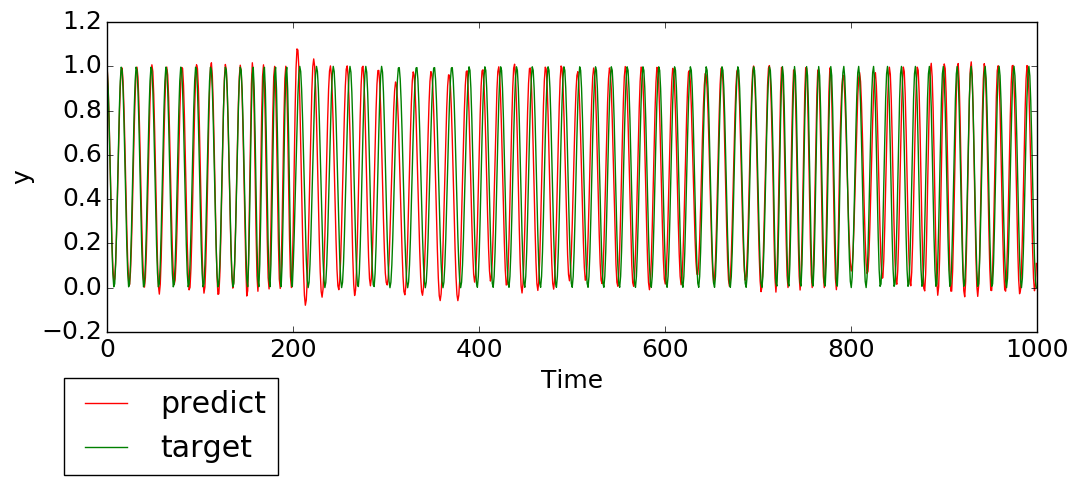

In [18]:
plt.figure(figsize=(12,4))
plt.plot(y_pred_test[:1000], 'r', label='predict')
plt.plot(y_test[:1000], 'g', label='target')
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(bbox_to_anchor=(0.2, -0.1))

## 出力のスペクトログラム

先ほどテスト用データの出力とモデルの出力に関してプロットしてみましたが、実際に周波数が一致しているのか分かり難かったと思います。そこで、ここでは出力をスペクトログラムに変換させます。これにより横軸は時間のままですが、縦軸を周波数にすることができます。図中の色が濃い箇所がその周波数成分が強い箇所となります。スペクトログラムに関しては[wikipedia](モデルの出力をプロットしてみます。ほぼ完璧に出力データと一致しているのが確認できると思います。)やscipyの[ドキュメント](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.pinv.html)を読んで下さい。

図より学習用データのみならずテスト用データの周波数もほぼ一致していることがわかると思います。

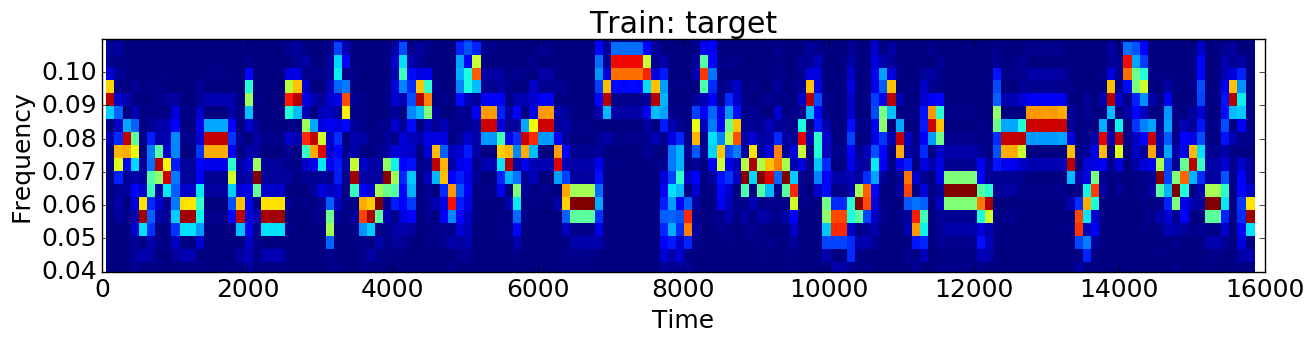

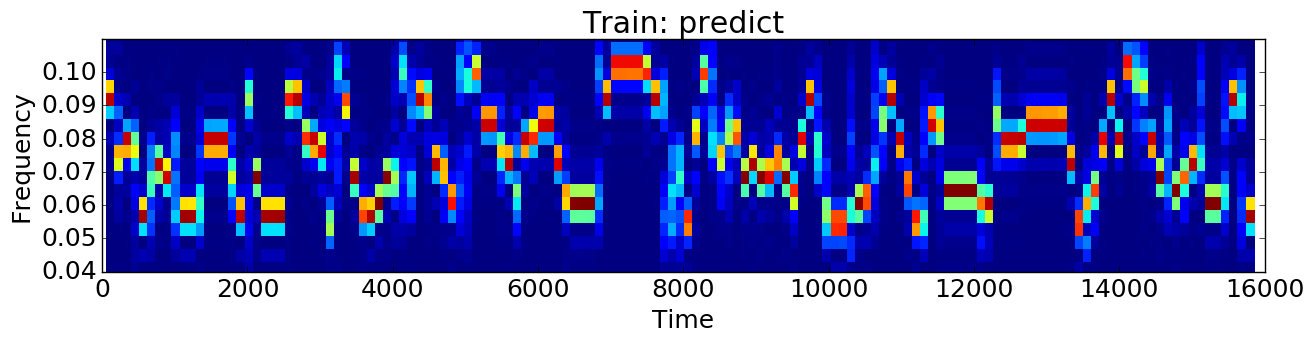

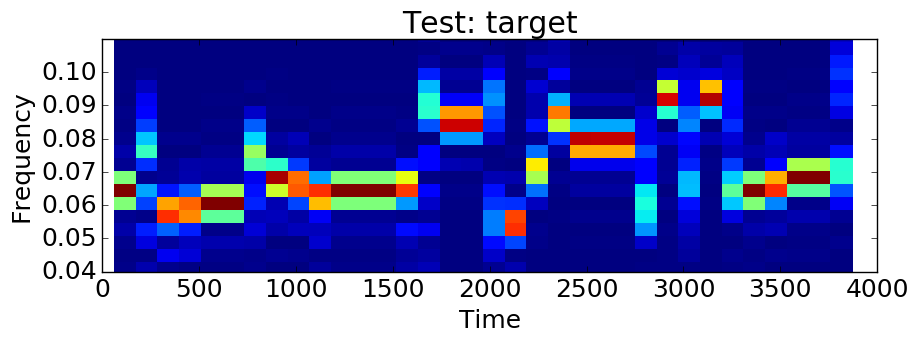

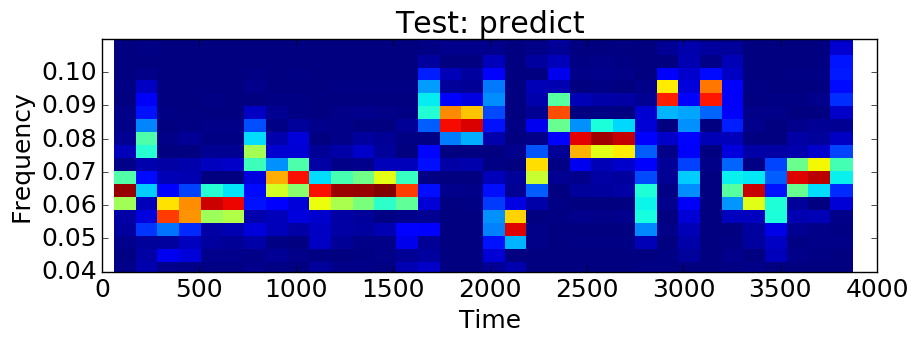

In [19]:
plt.rc('font', size=18) 
def plot_spectrogram(data):
    fs = 1
    f, t, Sxx = signal.spectrogram(data, fs, nfft=256, nperseg=128)
    plt.pcolormesh(t, f, Sxx)
    plt.ylim(0.04, 0.11)
    plt.ylabel("Frequency")
    plt.xlabel("Time")
    
plt.figure(figsize=(15,3))
plot_spectrogram(y_train.flatten())
plt.title("Train: target")
plt.figure(figsize=(15,3))
plot_spectrogram(y_pred_train.flatten())
plt.title("Train: predict")

plt.figure(figsize=(10,3))
plot_spectrogram(y_test.flatten())
plt.title("Test: target")
plt.figure(figsize=(10,3))
plot_spectrogram(y_pred_test.flatten())
plt.title("Test: predict")